## 1.2 ASHARE-Lgbm Simple FE WITH PYTHON

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2022.06.03 </div> 
<div style="text-align: right"> Last update: 2022.06.03</div> 

- https://www.kaggle.com/code/caesarlupum/ashrae-ligthgbm-simple-fe/notebook

### 라이브러리 import

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import datetime
import missingno as msno
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 150

In [2]:
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os,random, math, psutil, pickle  

In [59]:
from sklearn.preprocessing import LabelEncoder

from scipy import stats
from scipy.stats import skew

from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

### 데이터 읽기

In [3]:
print(os.listdir('data/ashrae-energy-prediction/'))

['building_metadata.csv', 'sample_submission.csv', 'test.csv', 'test_df.pkl', 'train.csv', 'train_df.pkl', 'weather_test.csv', 'weather_train.csv']


In [4]:
%%time
root = 'data/ashrae-energy-prediction/'

train_df = pd.read_csv(root +'train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

weather_train_df = pd.read_csv(root + 'weather_train.csv')
test_df = pd.read_csv(root + 'test.csv')
weather_test_df = pd.read_csv(root + 'weather_test.csv')
building_meta_df = pd.read_csv(root + 'building_metadata.csv')
sample_submission = pd.read_csv(root + 'sample_submission.csv')

CPU times: total: 15.4 s
Wall time: 15.4 s


### 데이터 사이즈

In [5]:
train_df.shape

(20216100, 4)

In [6]:
weather_train_df.shape

(139773, 9)

In [7]:
weather_test_df.shape

(277243, 9)

In [8]:
building_meta_df.shape

(1449, 6)

### 메모리 사이즈 줄이기

In [9]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [10]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


### 데이터 살펴보기

In [11]:
display(train_df)
display(train_df.columns.values)

display(weather_train_df.head())
display(weather_train_df.columns.values)

display(building_meta_df.head())
display(building_meta_df.columns.values)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000000
1,1,0,2016-01-01 00:00:00,0.000000
2,2,0,2016-01-01 00:00:00,0.000000
3,3,0,2016-01-01 00:00:00,0.000000
4,4,0,2016-01-01 00:00:00,0.000000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000
20216096,1445,0,2016-12-31 23:00:00,4.825000
20216097,1446,0,2016-12-31 23:00:00,0.000000
20216098,1447,0,2016-12-31 23:00:00,159.574997


array(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype=object)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


array(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'], dtype=object)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


array(['site_id', 'building_id', 'primary_use', 'square_feet',
       'year_built', 'floor_count'], dtype=object)

### 데이터 병합  
- convert timestamp
- convert string to category

In [12]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

building_meta_df['primary_use'] = building_meta_df['primary_use'].astype('category')

In [13]:
# 학습용 데이터에 있는 building id만 메타 데이터에서 추출

temp_df = train_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')
del temp_df['building_id']
train_df = pd.concat([train_df, temp_df], axis=1)

In [14]:
display(train_df.head())
display(train_df.shape)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN


(20216100, 9)

In [15]:
temp_df = test_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')

del temp_df['building_id']
test_df = pd.concat([test_df, temp_df], axis=1)
del temp_df, building_meta_df

날씨 데이터 병합

In [16]:
temp_df = train_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_train_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_test_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
test_df = pd.concat([test_df, temp_df], axis=1)

del temp_df, weather_train_df, weather_test_df

데이터 병합

In [17]:
train_df.to_pickle('data/train.pkl')
test_df.to_pickle('data/test.pkl')

del train_df, test_df

In [19]:
train_df = pd.read_pickle('data/train.pkl')
test_df = pd.read_pickle('data/test.pkl')

### Encoding Variable

Points of the compass
Compass points

The names of the compass point directions follow these rules:
> #### 16-wind compass rose
   - The eight half-winds are the direction points obtained by bisecting the angles between the principal winds. The half-winds are north-northeast (NNE), east-northeast (ENE), east-southeast (ESE), south-southeast (SSE), south-southwest (SSW), west-southwest (WSW), west-northwest (WNW) and north-northwest (NNW). The name of each half-wind is constructed by combining the names of the principal winds to either side, with the cardinal wind coming first and the intercardinal wind second.
   - The eight principal winds and the eight half-winds together form the 16-wind compass rose, with each compass point at a ​22 1⁄2° angle from its two neighbours.

In [20]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [21]:
# 바람 방향을 카테고리 변수로 바꾸는 함수
# 360도를 16개의 compass rose로 바꾼다
# 참고 : https://en.wikipedia.org/wiki/Points_of_the_compass#16-wind_compass_rose

def degToCompass(num):
    val=int((num/22.5))
    arr=[i for i in range(0,16)]
    return arr[(val % 16)]

In [24]:
le = LabelEncoder()

train_df['primary_use'] = le.fit_transform(train_df['primary_use']).astype(np.int8)
test_df['primary_use'] = le.fit_transform(test_df['primary_use']).astype(np.int8)

In [25]:
# 나이: 가장 최근에 지어진 빌딩년도에서 해당 빌딩의 나이를 뺀다
train_df['age'] = train_df['year_built'].max() - train_df['year_built'] + 1
test_df['age'] = test_df['year_built'].max() - test_df['year_built'] + 1

### Feature Selection

#### Find the optimal feature subset using an evaluation measure. The choice of evaluation metric distinguish the three main strategies of feature selection algorithms: the wrapper strategy, the filter strategy, and the embedded strategy.

    Filter methods:
        information gain
        chi-square test
        correlation coefficient
        variance threshold
    Wrapper methods:
        recursive feature elimination
        sequential feature selection algorithms
    Embedded methods:
        L1 (LASSO) regularization
        decision tree

In [29]:
def average_imputation(df, column_name):
    imputation = df.groupby(['timestamp'])[column_name].mean()
    
    df.loc[df[column_name].isnull(), column_name] = df[df[column_name].isnull()][[column_name]]\
                        .apply(lambda x: imputation[df['timestamp'][x.index]].values)
    del imputation
    return df

In [30]:
train_df = average_imputation(train_df, 'wind_speed')
train_df = average_imputation(train_df, 'wind_direction')

In [31]:
beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

for item in beaufort:
    train_df.loc[(train_df['wind_speed']>=item[1]) & (train_df['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

In [32]:
train_df['wind_direction'] = train_df['wind_direction'].apply(degToCompass)
train_df['beaufort_scale'] = train_df['beaufort_scale'].astype(np.uint8)
train_df["wind_direction"] = train_df['wind_direction'].astype(np.uint8)
train_df["meter"] = train_df['meter'].astype(np.uint8)
train_df["site_id"] = train_df['site_id'].astype(np.uint8)

In [33]:
test_df = average_imputation(test_df, 'wind_speed')
test_df = average_imputation(test_df, 'wind_direction')

for item in beaufort:
    test_df.loc[(test_df['wind_speed']>=item[1]) & (test_df['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

test_df['wind_direction'] = test_df['wind_direction'].apply(degToCompass)
test_df['wind_direction'] = test_df['wind_direction'].apply(degToCompass)
test_df['beaufort_scale'] = test_df['beaufort_scale'].astype(np.uint8)
test_df["wind_direction"] = test_df['wind_direction'].astype(np.uint8)
test_df["meter"] = test_df['meter'].astype(np.uint8)
test_df["site_id"] = test_df['site_id'].astype(np.uint8)

### Feature engineering

datetime

In [34]:
train_df['month_datetime'] = train_df['timestamp'].dt.month.astype(np.int8)
train_df['weekofyear_datetime'] = train_df['timestamp'].dt.weekofyear.astype(np.int8)
train_df['dayofyear_datetime'] = train_df['timestamp'].dt.dayofyear.astype(np.int16)
    
train_df['hour_datetime'] = train_df['timestamp'].dt.hour.astype(np.int8)  
train_df['day_week'] = train_df['timestamp'].dt.dayofweek.astype(np.int8)
train_df['day_month_datetime'] = train_df['timestamp'].dt.day.astype(np.int8)
train_df['week_month_datetime'] = train_df['timestamp'].dt.day/7
train_df['week_month_datetime'] = train_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
    
test_df['month_datetime'] = test_df['timestamp'].dt.month.astype(np.int8)
test_df['weekofyear_datetime'] = test_df['timestamp'].dt.weekofyear.astype(np.int8)
test_df['dayofyear_datetime'] = test_df['timestamp'].dt.dayofyear.astype(np.int16)
    
test_df['hour_datetime'] = test_df['timestamp'].dt.hour.astype(np.int8)
test_df['day_week'] = test_df['timestamp'].dt.dayofweek.astype(np.int8)
test_df['day_month_datetime'] = test_df['timestamp'].dt.day.astype(np.int8)
test_df['week_month_datetime'] = test_df['timestamp'].dt.day/7
test_df['week_month_datetime'] = test_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)

In [37]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,age,beaufort_scale,month_datetime,weekofyear_datetime,dayofyear_datetime,hour_datetime,day_week,day_month_datetime,week_month_datetime
0,0,0,2016-01-01,0.0,0,0,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0,0.0,10.0,0,1,53,1,0,4,1,1
1,1,0,2016-01-01,0.0,0,0,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0,0.0,14.0,0,1,53,1,0,4,1,1
2,2,0,2016-01-01,0.0,0,0,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0,0.0,27.0,0,1,53,1,0,4,1,1
3,3,0,2016-01-01,0.0,0,0,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0,0.0,16.0,0,1,53,1,0,4,1,1
4,4,0,2016-01-01,0.0,0,0,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0,0.0,43.0,0,1,53,1,0,4,1,1


In [38]:
train_df.shape

(20216100, 25)

In [39]:
train_df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'age', 'beaufort_scale', 'month_datetime',
       'weekofyear_datetime', 'dayofyear_datetime', 'hour_datetime',
       'day_week', 'day_month_datetime', 'week_month_datetime'],
      dtype='object')

### EDA

타겟

<AxesSubplot:>

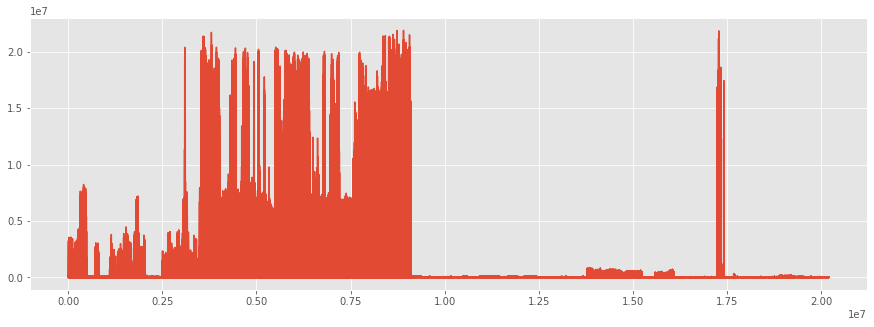

In [40]:
plt.figure(figsize = (15, 5))
train_df['meter_reading'].plot()

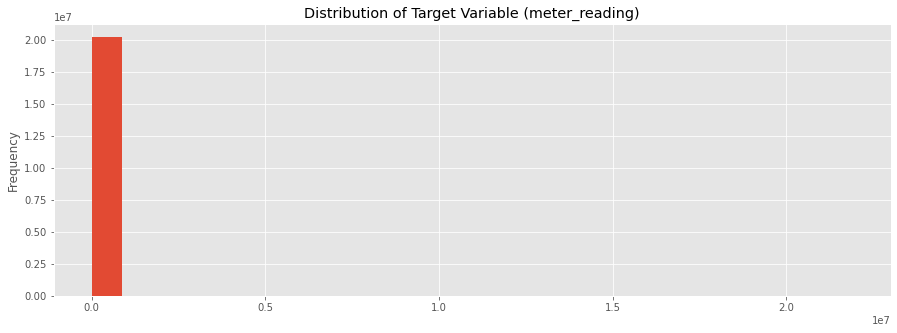

In [41]:
train_df['meter_reading'].plot(kind='hist',
                            bins=25,
                            figsize=(15, 5),
                           title='Distribution of Target Variable (meter_reading)')
plt.show()

target의 log histogram

count    2.021610e+07
mean     1.988706e+03
std      1.532159e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

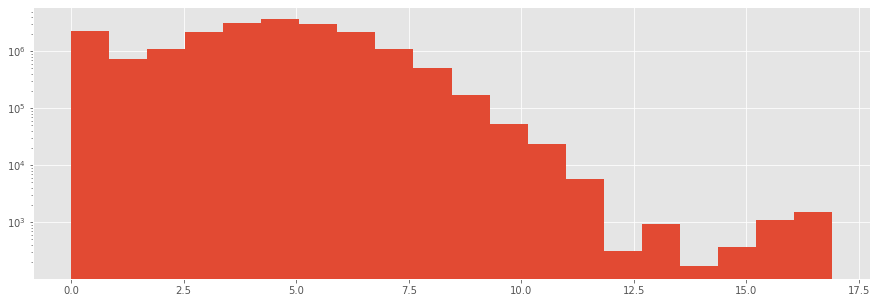

In [44]:
plt.figure(figsize = (15, 5))
ax = np.log1p(train_df['meter_reading']).hist(bins = 20)
ax.set_yscale('log')
train_df.meter_reading.describe()

### 결측치 확인

In [45]:
total = train_df.isnull().sum().sort_values(ascending=False)

percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_data.head(10)

,Total,Percent
floor_count,16709167,82.652772
age,12127645,59.990033
year_built,12127645,59.990033
cloud_coverage,8825365,43.655131
precip_depth_1_hr,3749023,18.544739
sea_level_pressure,1231669,6.092515
dew_temperature,100140,0.495348
air_temperature,96658,0.478124
day_month_datetime,0,0.000000
day_week,0,0.000000


### 컬럼 타입

In [46]:
train_df.dtypes

building_id                     int16
meter                           uint8
timestamp              datetime64[ns]
meter_reading                 float32
site_id                         uint8
primary_use                      int8
square_feet                     int32
year_built                    float16
floor_count                   float16
air_temperature               float16
cloud_coverage                float16
dew_temperature               float16
precip_depth_1_hr             float16
sea_level_pressure            float16
wind_direction                  uint8
wind_speed                    float16
age                           float16
beaufort_scale                  uint8
month_datetime                   int8
weekofyear_datetime              int8
dayofyear_datetime              int16
hour_datetime                    int8
day_week                         int8
day_month_datetime               int8
week_month_datetime              int8
dtype: object

In [47]:
train_df.dtypes.value_counts()

float16           9
int8              7
uint8             4
int16             2
datetime64[ns]    1
float32           1
int32             1
dtype: int64

In [50]:
train_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

### 결측치 처리

In [51]:
import missingno as msno

<AxesSubplot:>

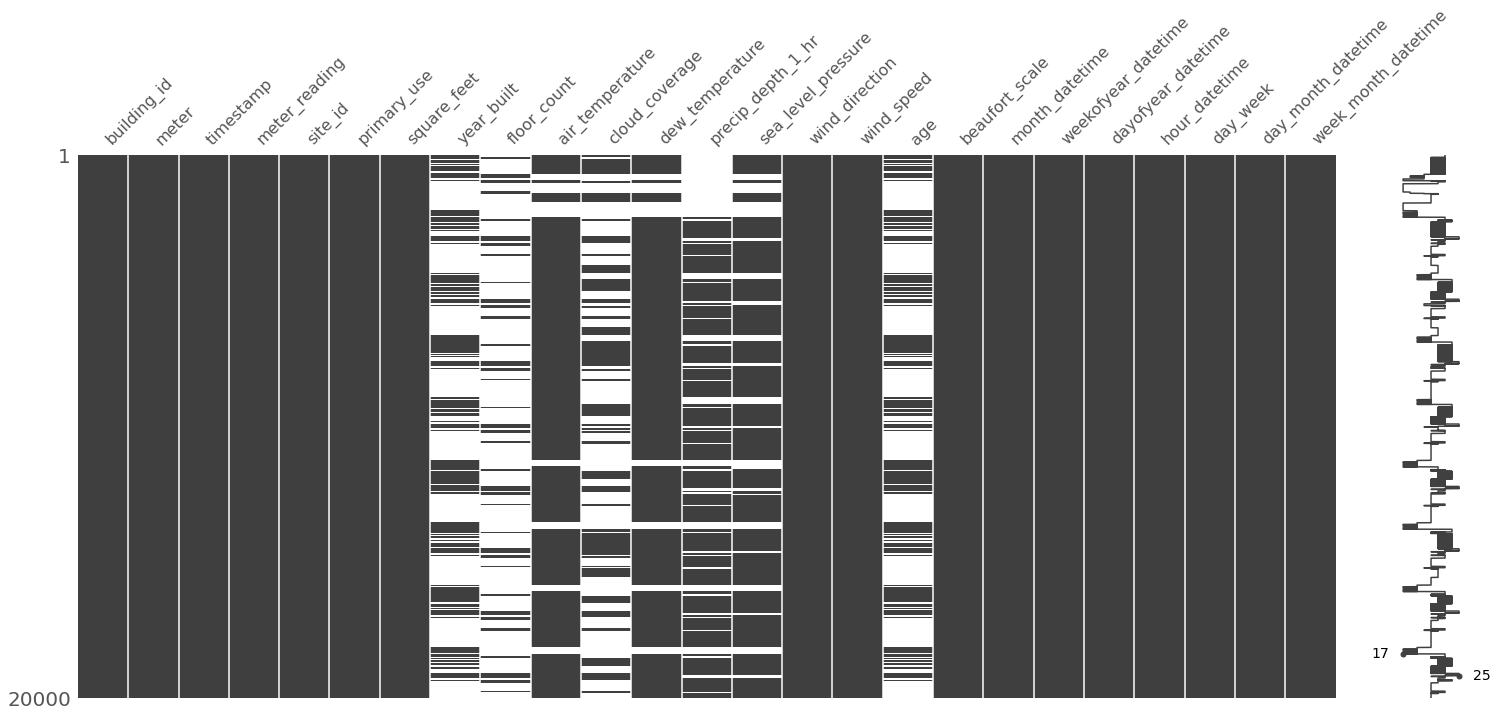

In [52]:
msno.matrix(train_df.head(20000))

heatmap?

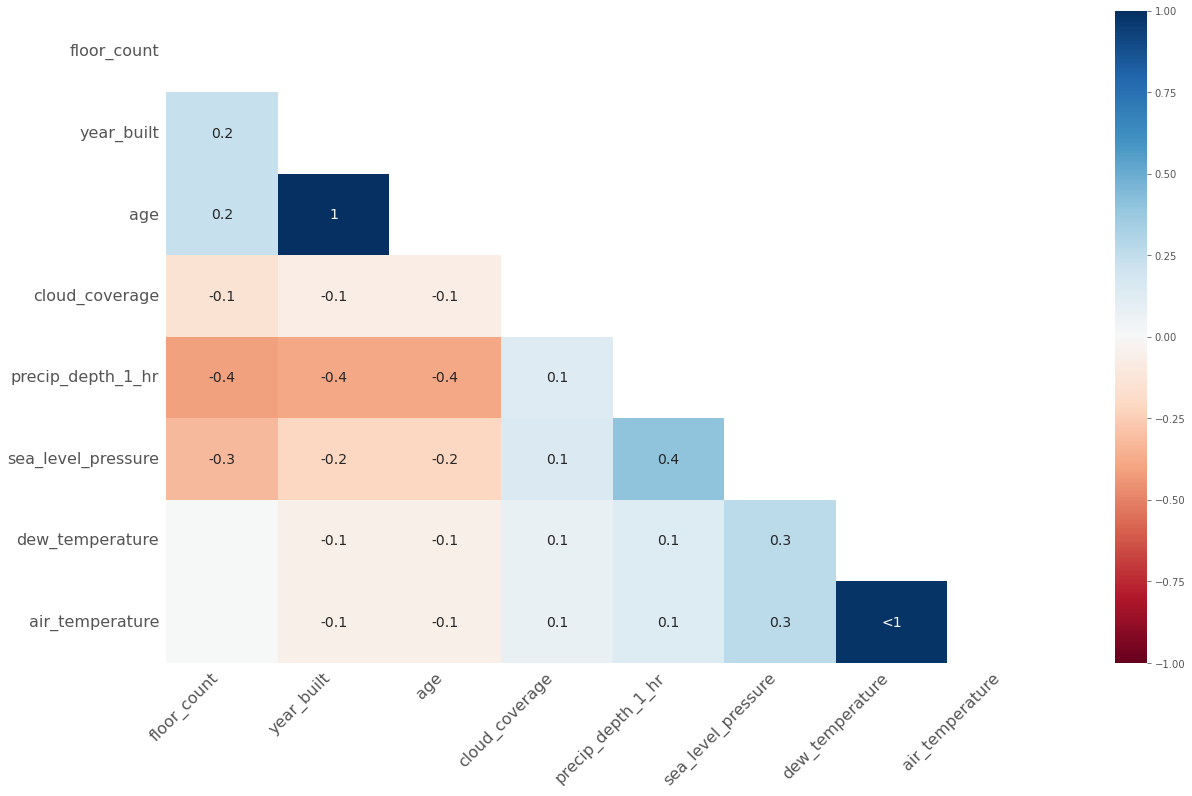

In [53]:
a = msno.heatmap(train_df, sort='ascending')

결측치가 많은 컬럼에서, 결측치를 -999를 입력해보자.

In [54]:
train_df['floor_count'] = train_df['floor_count'].fillna(-999).astype(np.int16)
test_df['floor_count'] = test_df['floor_count'].fillna(-999).astype(np.int16)

train_df['year_built'] = train_df['year_built'].fillna(-999).astype(np.int16)
test_df['year_built'] = test_df['year_built'].fillna(-999).astype(np.int16)

train_df['age'] = train_df['age'].fillna(-999).astype(np.int16)
test_df['age'] = test_df['age'].fillna(-999).astype(np.int16)

train_df['cloud_coverage'] = train_df['cloud_coverage'].fillna(-999).astype(np.int16)
test_df['cloud_coverage'] = test_df['cloud_coverage'].fillna(-999).astype(np.int16) 

### Outlier analysis

In [55]:
energy_types_dict = {0: "electricity", 1: "chilledwater", 2: "steam", 3: "hotwater"}
energy_types      = ['electricity', 'chilledwater', 'steam', 'hotwater']

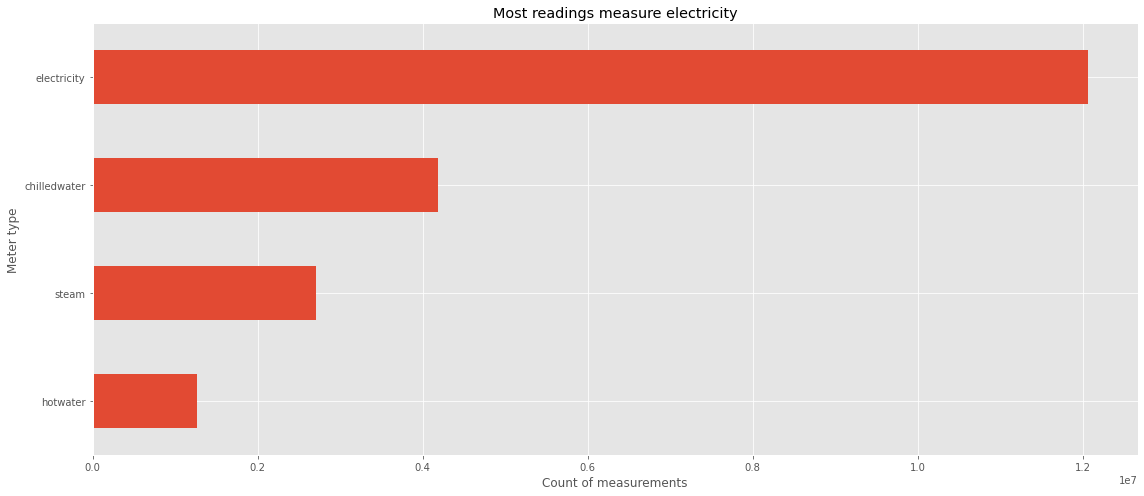

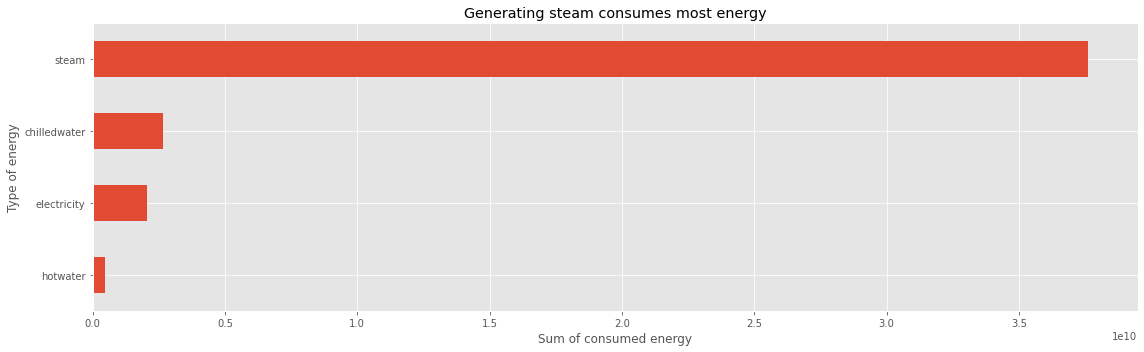

In [56]:
plt.figure(figsize=(16, 7))
tmp_df = train_df['meter'].value_counts()
tmp_df.index = energy_types
tmp_df.sort_values().plot(kind='barh')
plt.title(f"Most readings measure electricity")
plt.xlabel("Count of measurements")
plt.ylabel(f"Meter type")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,5))
tmp_df = train_df.groupby("meter").meter_reading.sum()
tmp_df.index = energy_types
tmp_df.sort_values().plot(kind="barh")
plt.title(f"Generating steam consumes most energy")
plt.xlabel("Sum of consumed energy")
plt.ylabel(f"Type of energy")
plt.tight_layout()
plt.show()

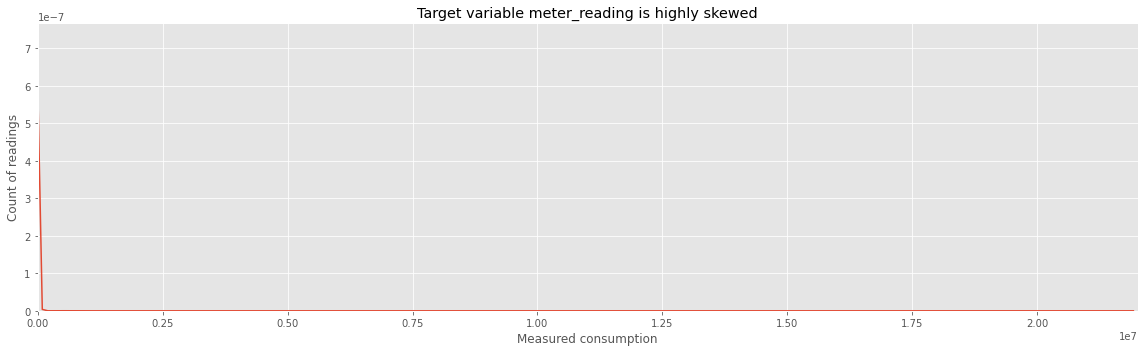

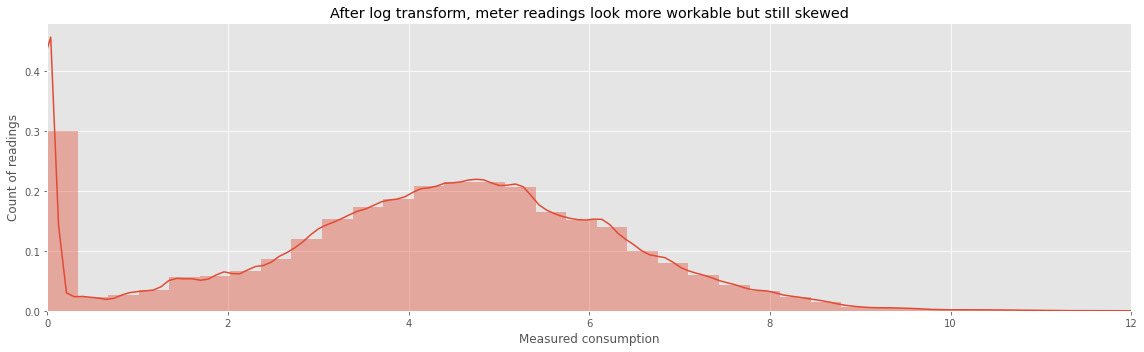

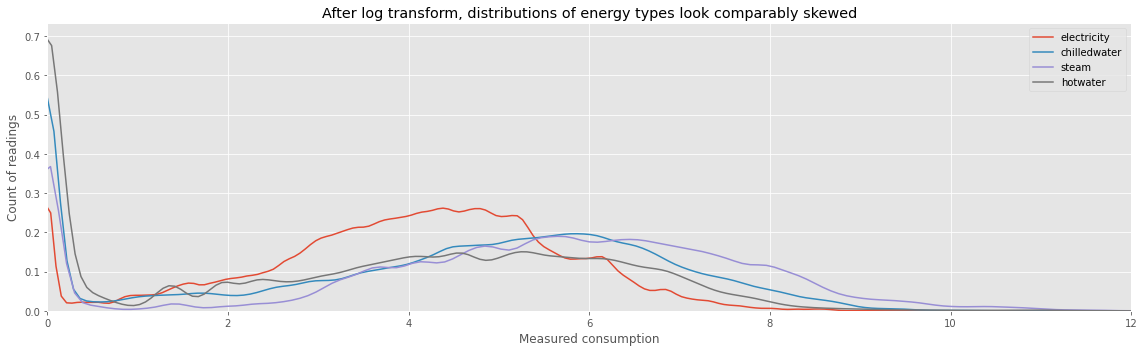

In [57]:
plt.figure(figsize=(16,5))
sns.distplot(train_df.meter_reading, hist=False)
plt.title(f"Target variable meter_reading is highly skewed")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.xlim(0, train_df.meter_reading.max() + 100_000)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,5))
sns.distplot(np.log1p(train_df.meter_reading))
plt.title(f"After log transform, meter readings look more workable but still skewed")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.xlim(0, 12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,5))
for idx in range(0,4):
    sns.distplot(np.log1p(train_df[train_df.meter==idx].meter_reading), hist=False, label=energy_types[idx])
plt.title(f"After log transform, distributions of energy types look comparably skewed")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.legend()
plt.xlim(0, 12)
plt.tight_layout()
plt.show()

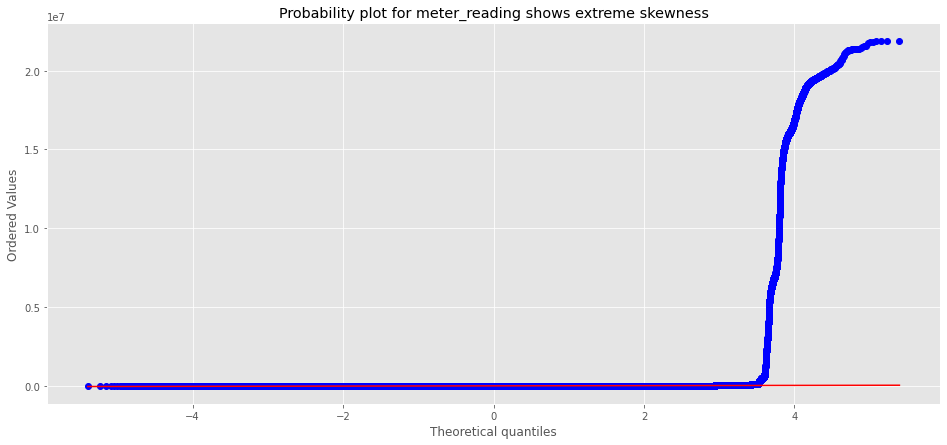

In [60]:
plt.figure(figsize=(16,7))
_ = stats.probplot(train_df['meter_reading'], plot=plt)
plt.title("Probability plot for meter_reading shows extreme skewness")
plt.show()

10개 빌딩에 대한 미터리딩 합계

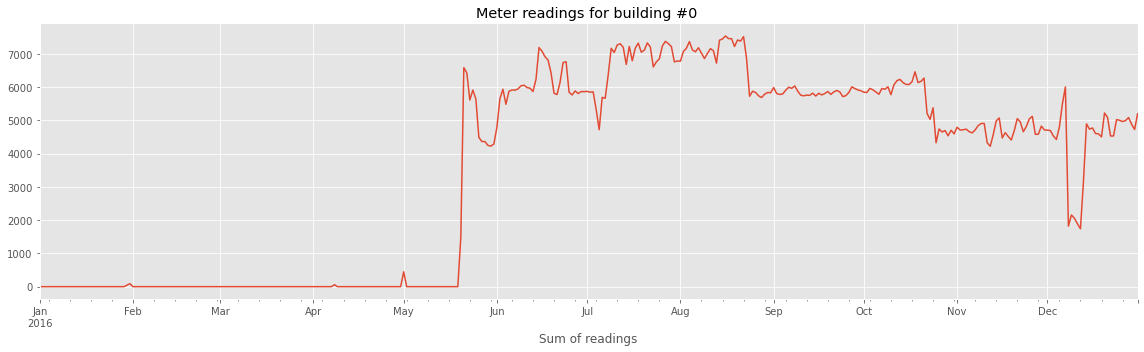

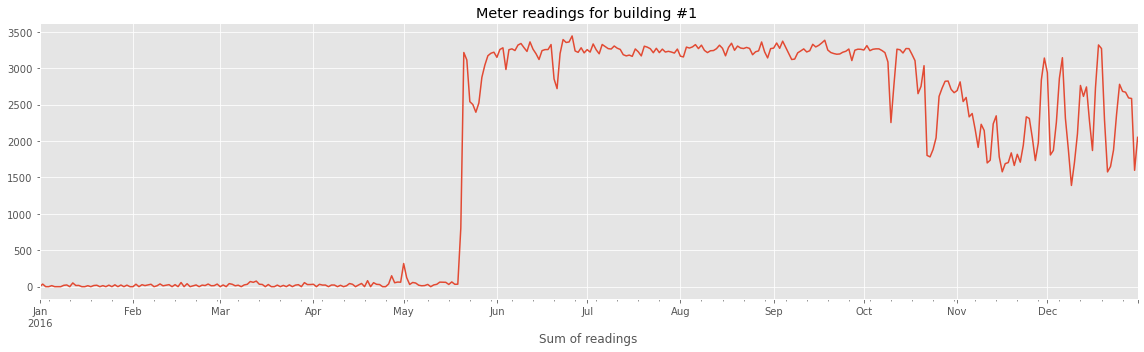

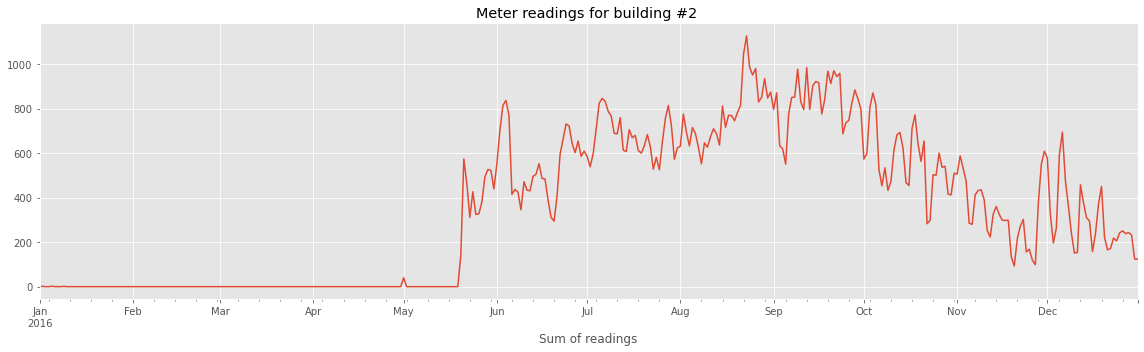

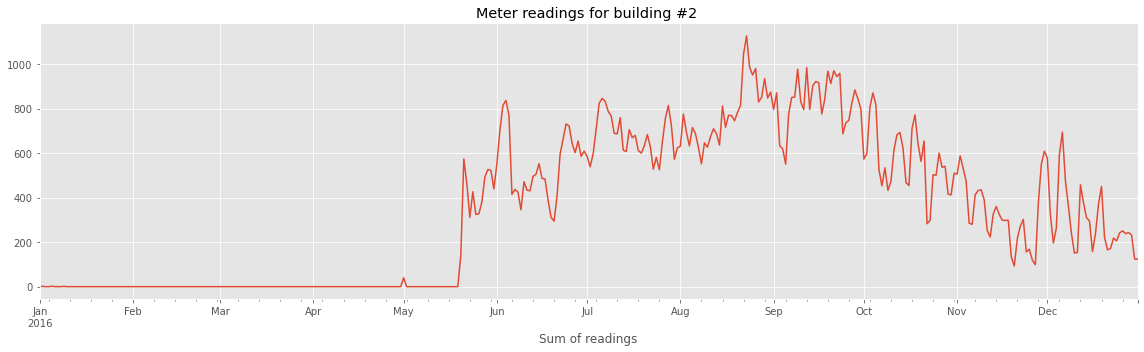

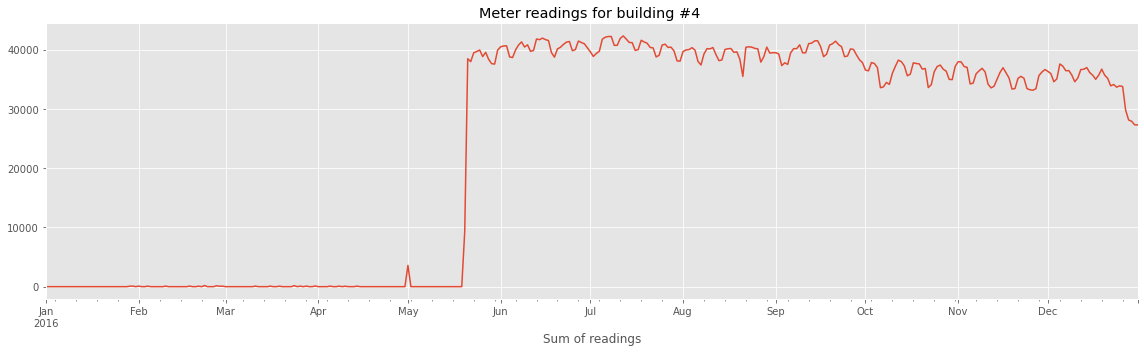

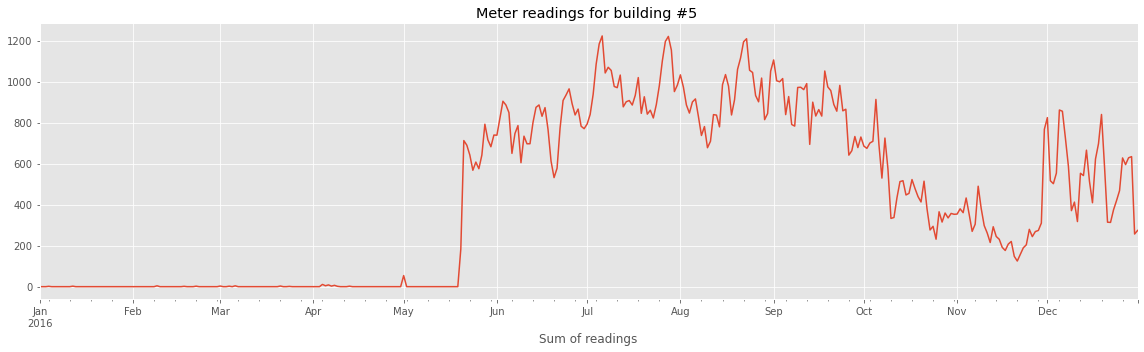

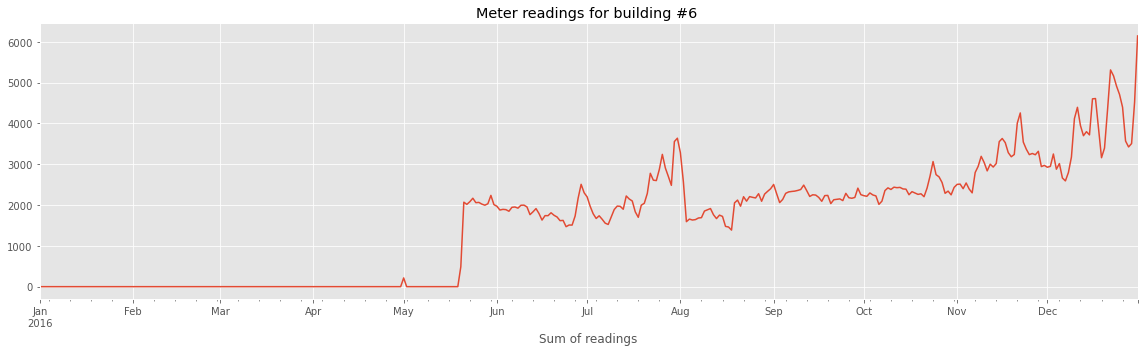

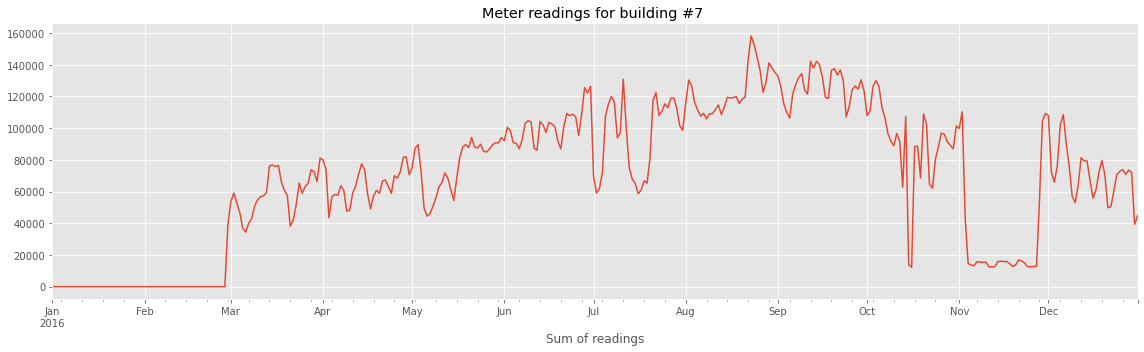

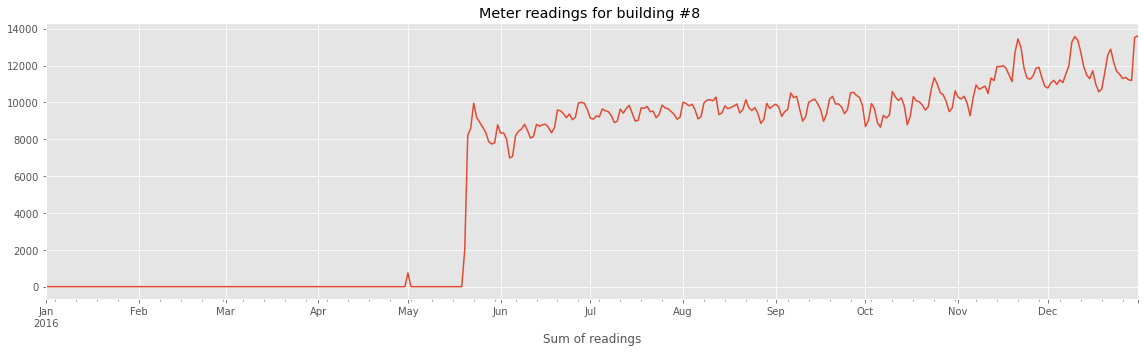

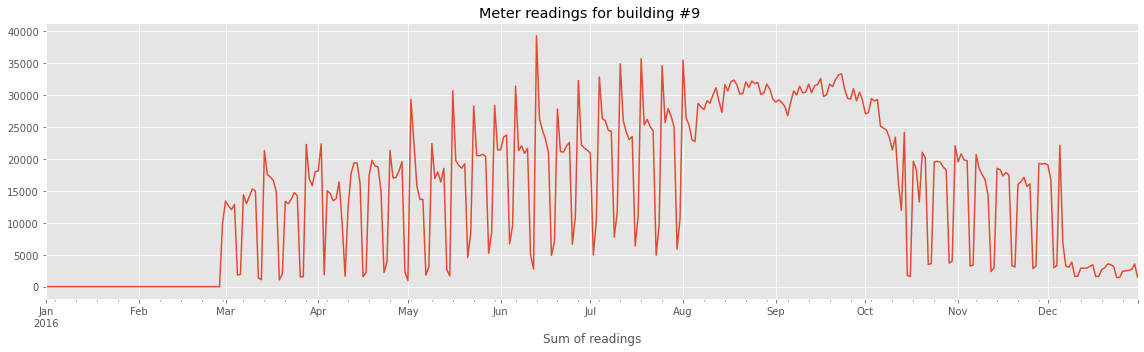

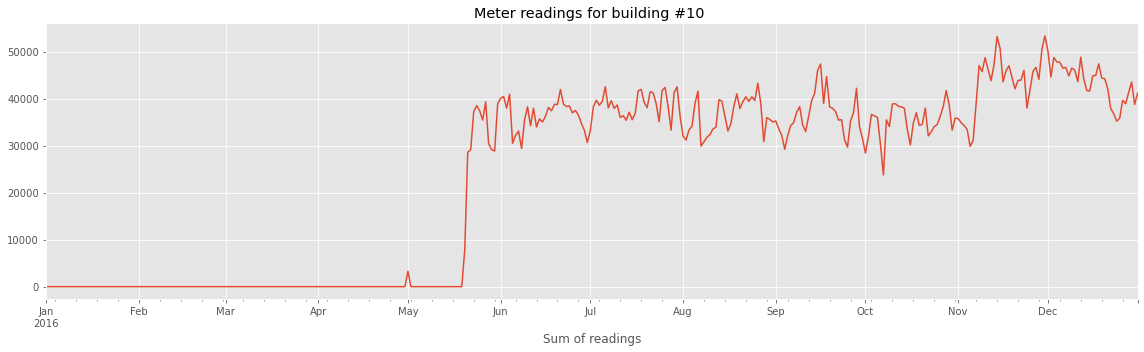

In [61]:
for bldg_id in [0, 1, 2, 2, 4,5, 6,7,8,9,10]:
    plt.figure(figsize=(16,5))
    tmp_df = train_df[train_df.building_id == bldg_id].copy()
    tmp_df.set_index("timestamp", inplace=True)
    tmp_df.resample("D").meter_reading.sum().plot()
    plt.title(f"Meter readings for building #{bldg_id} ")
    plt.xlabel("Sum of readings")
    plt.tight_layout()
    plt.show()

primary use 빈도 확인

In [63]:
temp_df = train_df.groupby("primary_use").meter_reading.sum().sort_values()

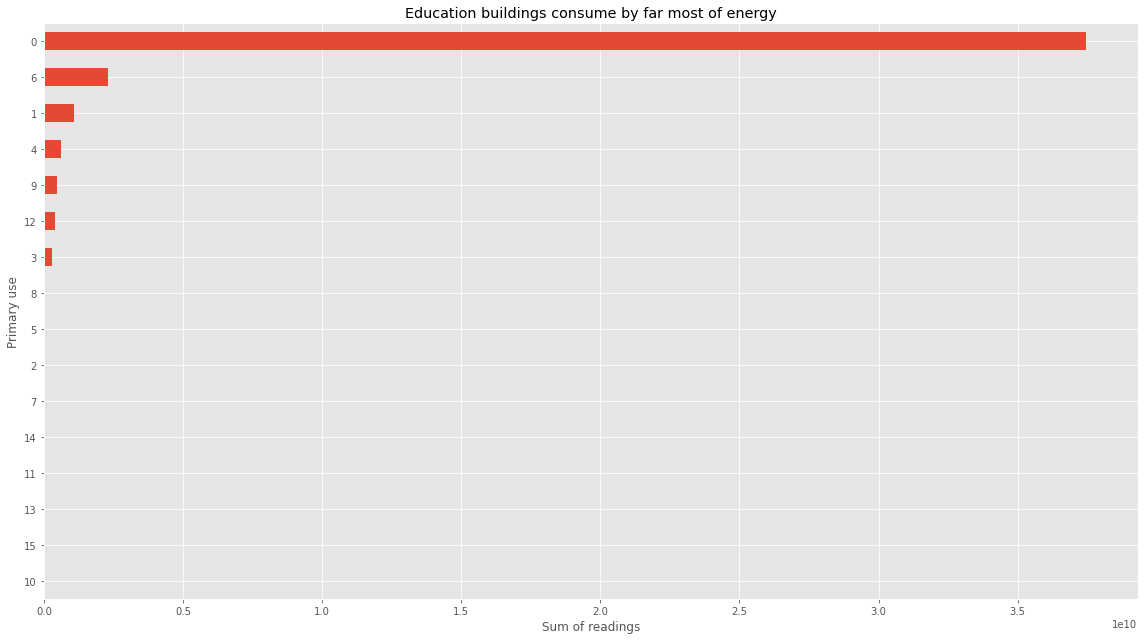

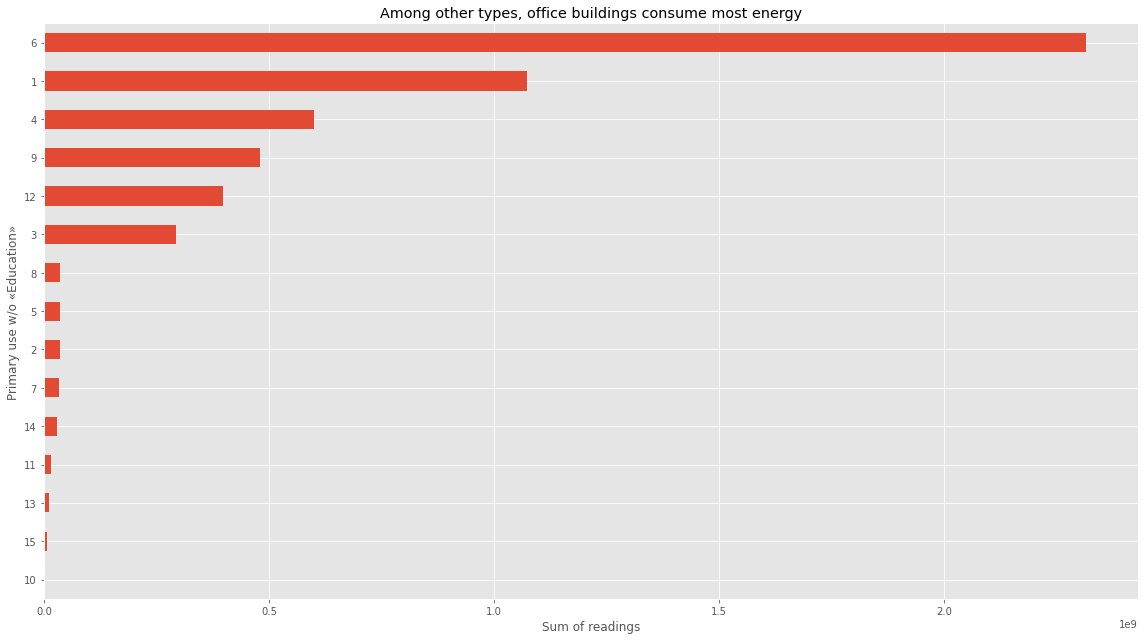

In [64]:
plt.figure(figsize=(16,9))
temp_df.plot(kind="barh")
plt.title(f"Education buildings consume by far most of energy")
plt.xlabel("Sum of readings")
plt.ylabel(f"Primary use")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,9))
temp_df[:-1].plot(kind="barh")
plt.title(f"Among other types, office buildings consume most energy")
plt.xlabel("Sum of readings")
plt.ylabel(f"Primary use w/o «Education»")
plt.tight_layout()
plt.show()

### Outlier distribution

In [65]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,age,beaufort_scale,month_datetime,weekofyear_datetime,dayofyear_datetime,hour_datetime,day_week,day_month_datetime,week_month_datetime
0,0,0,2016-01-01,0.0,0,0,7432,2008,-999,25.0,6,20.0,NaN,1019.5,0,0.0,10,0,1,53,1,0,4,1,1
1,1,0,2016-01-01,0.0,0,0,2720,2004,-999,25.0,6,20.0,NaN,1019.5,0,0.0,14,0,1,53,1,0,4,1,1
2,2,0,2016-01-01,0.0,0,0,5376,1991,-999,25.0,6,20.0,NaN,1019.5,0,0.0,27,0,1,53,1,0,4,1,1
3,3,0,2016-01-01,0.0,0,0,23685,2002,-999,25.0,6,20.0,NaN,1019.5,0,0.0,16,0,1,53,1,0,4,1,1
4,4,0,2016-01-01,0.0,0,0,116607,1975,-999,25.0,6,20.0,NaN,1019.5,0,0.0,43,0,1,53,1,0,4,1,1


In [66]:
train_df.tail()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,age,beaufort_scale,month_datetime,weekofyear_datetime,dayofyear_datetime,hour_datetime,day_week,day_month_datetime,week_month_datetime
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,1,19619,1914,-999,1.700195,-999,-5.601562,-1.0,1008.5,8,8.796875,104,5,12,52,366,23,5,31,5
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,0,4298,-999,-999,1.700195,-999,-5.601562,-1.0,1008.5,8,8.796875,-999,5,12,52,366,23,5,31,5
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,1,11265,1997,-999,1.700195,-999,-5.601562,-1.0,1008.5,8,8.796875,21,5,12,52,366,23,5,31,5
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,4,29775,2001,-999,1.700195,-999,-5.601562,-1.0,1008.5,8,8.796875,17,5,12,52,366,23,5,31,5
20216099,1448,0,2016-12-31 23:00:00,2.850000,15,6,92271,2001,-999,1.700195,-999,-5.601562,-1.0,1008.5,8,8.796875,17,5,12,52,366,23,5,31,5


<AxesSubplot:xlabel='timestamp'>

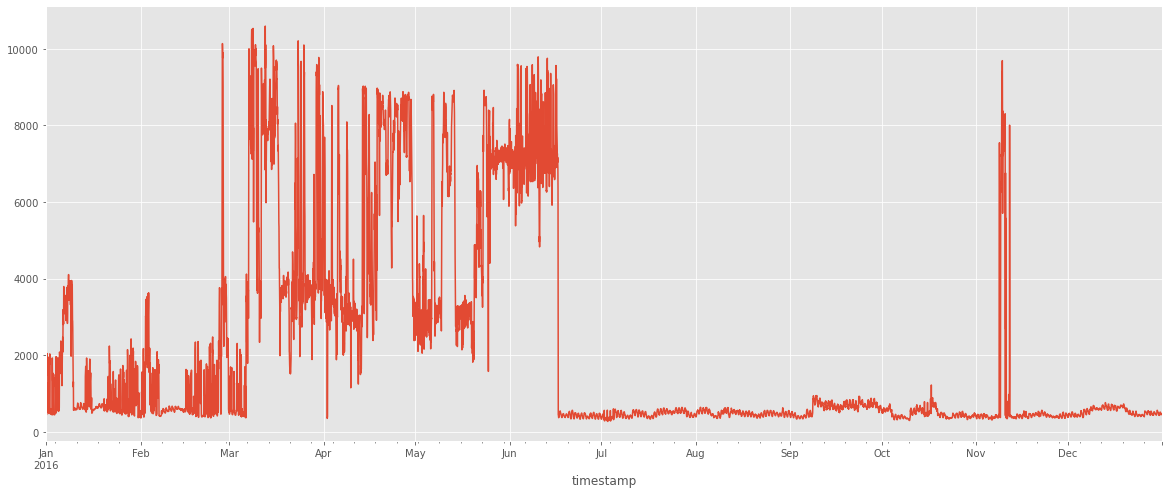

In [67]:
y_mean_time = train_df.groupby('timestamp')['meter_reading'].mean()
y_mean_time.plot(figsize = (20, 8))

In [69]:
y_mean_time.head()

timestamp
2016-01-01 00:00:00    1830.197144
2016-01-01 01:00:00    1854.113525
2016-01-01 02:00:00     547.888367
2016-01-01 03:00:00     439.471741
2016-01-01 04:00:00     509.867371
Name: meter_reading, dtype: float32

In [72]:
y_mean_time.rolling(window=10).std().head()

timestamp
2016-01-01 00:00:00   NaN
2016-01-01 01:00:00   NaN
2016-01-01 02:00:00   NaN
2016-01-01 03:00:00   NaN
2016-01-01 04:00:00   NaN
Name: meter_reading, dtype: float64

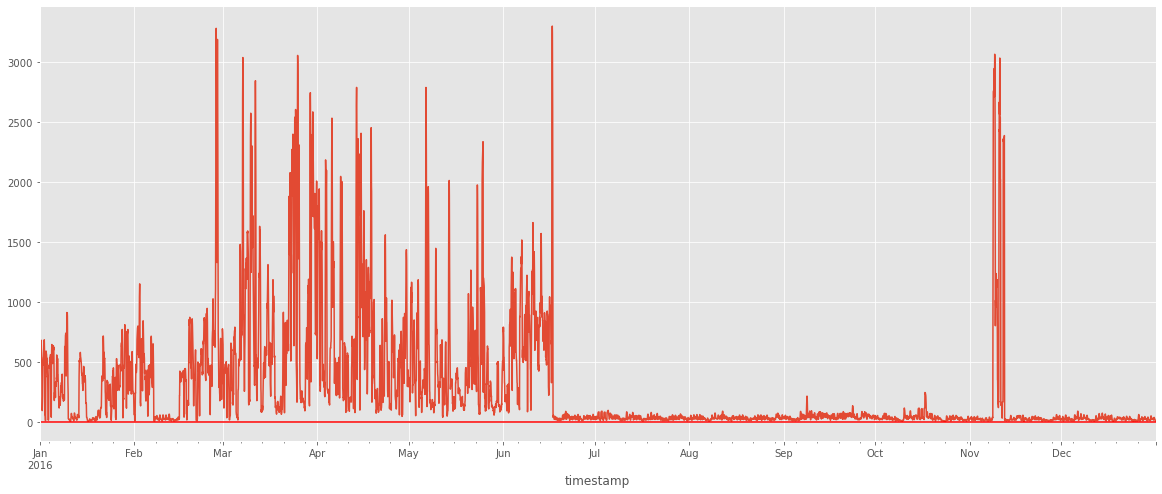

In [73]:
y_mean_time.rolling(window=10).std().plot(figsize=(20, 8))
plt.axhline(y=0.009, color='red')
plt.axvspan(0, 905, color='green', alpha=0.1)
plt.axvspan(906, 1505, color='red', alpha=0.1)

In [74]:
daily_train = train_df
daily_train['date'] = daily_train['timestamp'].dt.date
daily_train = daily_train.groupby(['date', 'building_id', 'meter']).sum()
daily_train

meter_reading  site_id  primary_use  \
date       building_id meter                                        
2016-01-01 0           0           0.000000      0.0          0.0   
           1           0           0.000000      0.0          0.0   
           2           0           0.000000      0.0          0.0   
           3           0           0.000000      0.0          0.0   
           4           0           0.000000      0.0          0.0   
...                                     ...      ...          ...   
2016-12-31 1444        0         177.175003    360.0         24.0   
           1445        0         134.250000    360.0          0.0   
           1446        0          31.650000    360.0         24.0   
           1447        0        3757.199951    360.0         96.0   
           1448        0          79.974998    360.0        144.0   

                              square_feet  year_built  floor_count  \
date       building_id meter                                         
2016-01-01 0           0           178368     48192.0     -23976.0   
           1           0            65280     48096.0     -23976.0   
           2           0           129024     47784.0     -23976.0   
           3           0           568440     48048.0     -23976.0   
           4           0          2798568     47400.0     -23976.0   
...                                   ...         ...          ...   
2016-12-31 1444        0           470856     45936.0     -23976.0   
           1445        0           103152    -23976.0     -23976.0   
           1446        0           270360     47928.0     -23976.0   
           1447        0           714600     48024.0     -23976.0   
           1448        0          2214504     48024.0     -23976.0   

                              air_temperature  cloud_coverage  \
date       building_id meter                                    
2016-01-01 0           0            560.00000          -16953   
           1           0            560.00000          -16953   
           2           0            560.00000          -16953   
           3           0            560.00000          -16953   
           4           0            560.00000          -16953   
...                                       ...             ...   
2016-12-31 1444        0            -39.59375          -20973   
           1445        0            -39.59375          -20973   
           1446        0            -39.59375          -20973   
           1447        0            -39.59375          -20973   
           1448        0            -39.59375          -20973   

                              dew_temperature  precip_depth_1_hr  \
date       building_id meter                                       
2016-01-01 0           0              480.500               -4.0   
           1           0              480.500               -4.0   
           2           0              480.500               -4.0   
           3           0              480.500               -4.0   
           4           0              480.500               -4.0   
...                                       ...                ...   
2016-12-31 1444        0             -176.125               -6.0   
           1445        0             -176.125               -6.0   
           1446        0             -176.125               -6.0   
           1447        0             -176.125               -6.0   
           1448        0             -176.125               -6.0   

                              sea_level_pressure  wind_direction  wind_speed  \
date       building_id meter                                                   
2016-01-01 0           0                 23440.0           126.0       44.50   
           1           0                 23440.0           126.0       44.50   
           2           0                 23440.0           126.0       44.50   
           3           0                 23440.0           126.0       44.50   
          

In [75]:
daily_train_agg = daily_train.groupby(['date', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])

In [76]:
daily_train_agg.head()

meter_reading                                        \
                           sum           mean                 idxmax   
date       meter                                                       
2016-01-01 0      4.219648e+06    3037.903076   (2016-01-01, 803, 0)   
           1      1.412169e+06    3090.084961  (2016-01-01, 1289, 1)   
           2      6.873201e+07  218891.734375  (2016-01-01, 1099, 2)   
           3      1.609989e+06   11180.481445  (2016-01-01, 1331, 3)   
2016-01-02 0      4.288951e+06    3085.576416   (2016-01-02, 803, 0)   

                                 site_id                                     \
                           max       sum        mean                 idxmax   
date       meter                                                              
2016-01-01 0      1.160372e+05  228225.0  164.308855  (2016-01-01, 1326, 0)   
           1      1.042116e+05  107738.0  235.750547  (2016-01-01, 1326, 1)   
           2      5.095080e+07   87728.0  279.388535  (2016-01-01, 1326, 2)   
           3      2.198245e+05   26526.0  184.208333  (2016-01-01, 1325, 3)   
2016-01-02 0      1.157768e+05  228472.0  164.368345  (2016-01-02, 1326, 0)   

                        primary_use                                           \
                    max         sum       mean                 idxmax    max   
date       meter                                                               
2016-01-01 0      360.0    114087.0  82.136069   (2016-01-01, 164, 0)  360.0   
           1      360.0     30432.0  66.590810   (2016-01-01, 285, 1)  336.0   
           2      360.0     21726.0  69.191083  (2016-01-01, 1155, 2)  360.0   
           3      360.0      8672.0  60.222222  (2016-01-01, 1017, 3)  312.0   
2016-01-02 0      360.0    114334.0  82.254676   (2016-01-02, 164, 0)  360.0   

                   square_feet                                                 \
                           sum          mean                 idxmax       max   
date       meter                                                                
2016-01-01 0      3.084661e+09  2.220778e+06   (2016-01-01, 869, 0)  21000000   
           1      1.409027e+09  3.083211e+06  (2016-01-01, 1148, 1)  20676576   
           2      1.061216e+09  3.379670e+06  (2016-01-01, 1148, 2)  20676576   
           3      3.903113e+08  2.710495e+06   (2016-01-01, 794, 3)  17566680   
2016-01-02 0      3.084779e+09  2.219266e+06   (2016-01-02, 869, 0)  21000000   

                  year_built                                               \
                         sum         mean                 idxmax      max   
date       meter                                                            
2016-01-01 0      12782697.0  9202.805616   (2016-01-01, 363, 0)  48408.0   
           1       -571074.0 -1249.614880   (2016-01-01, 181, 1)  48336.0   
           2      -2603718.0 -8292.095541  (2016-01-01, 1373, 2)  48336.0   
           3       1171616.0  8136.222222   (2016-01-01, 179, 3)  48288.0   
2016-01-02 0      12724077.0  9154.012230   (2016-01-02, 363, 0)  48408.0   

                 floor_count                                             \
                         sum          mean                idxmax    max   
date       meter                                                          
2016-01-01 0     -25091007.0 -18064.079914  (2016-01-01, 799, 0)  624.0   
           1     -10312026.0 -22564.608315  (2016-01-01, 799, 1)  624.0   
           2      -7216182.0 -22981.471338  (2016-01-01, 799, 2)  624.0   
           3      -2775099.0 -19271.520833  (2016-01-01, 114, 3)  312.0   
2016-01-02 0     -25067986.0 -18034.522302  (2016-01-02, 799, 0)  624.0   

                 air_temperature                                            \
                             sum        mean                idxmax     max   
date       meter                                                             
2016-01-01 0                 inf  153.375000    (2016-01-01, 0, 0

In [77]:
daily_train_agg = daily_train_agg.reset_index()

In [78]:
daily_train_agg

date meter meter_reading                                        \
                                 sum           mean                 idxmax   
0     2016-01-01     0  4.219648e+06    3037.903076   (2016-01-01, 803, 0)   
1     2016-01-01     1  1.412169e+06    3090.084961  (2016-01-01, 1289, 1)   
2     2016-01-01     2  6.873201e+07  218891.734375  (2016-01-01, 1099, 2)   
3     2016-01-01     3  1.609989e+06   11180.481445  (2016-01-01, 1331, 3)   
4     2016-01-02     0  4.288951e+06    3085.576416   (2016-01-02, 803, 0)   
...          ...   ...           ...            ...                    ...   
1459  2016-12-30     3  2.077853e+06   14330.019531  (2016-12-30, 1021, 3)   
1460  2016-12-31     0  5.066865e+06    3608.878418   (2016-12-31, 799, 0)   
1461  2016-12-31     1  2.102037e+06    4246.539551    (2016-12-31, 50, 1)   
1462  2016-12-31     2  1.718295e+07   53033.812500  (2016-12-31, 1168, 2)   
1463  2016-12-31     3  2.086813e+06   14391.812500  (2016-12-31, 1021, 3)   

                     site_id                                            \
               max       sum        mean                 idxmax    max   
0     1.160372e+05  228225.0  164.308855  (2016-01-01, 1326, 0)  360.0   
1     1.042116e+05  107738.0  235.750547  (2016-01-01, 1326, 1)  360.0   
2     5.095080e+07   87728.0  279.388535  (2016-01-01, 1326, 2)  360.0   
3     2.198245e+05   26526.0  184.208333  (2016-01-01, 1325, 3)  360.0   
4     1.157768e+05  228472.0  164.368345  (2016-01-02, 1326, 0)  360.0   
...            ...       ...         ...                    ...    ...   
1459  5.124206e+05   27152.0  187.255172  (2016-12-30, 1325, 3)  360.0   
1460  1.343883e+05  230336.0  164.056980  (2016-12-31, 1325, 0)  360.0   
1461  8.256347e+04  109830.0  221.878788  (2016-12-31, 1326, 1)  360.0   
1462  1.324875e+06   91073.0  281.089506  (2016-12-31, 1326, 2)  360.0   
1463  4.132599e+05   27174.0  187.406897  (2016-12-31, 1325, 3)  360.0   

     primary_use                                            square_feet  \
             sum       mean                 idxmax    max           sum   
0       114087.0  82.136069   (2016-01-01, 164, 0)  360.0  3.084661e+09   
1        30432.0  66.590810   (2016-01-01, 285, 1)  336.0  1.409027e+09   
2        21726.0  69.191083  (2016-01-01, 1155, 2)  360.0  1.061216e+09   
3         8672.0  60.222222  (2016-01-01, 1017, 3)  312.0  3.903113e+08   
4       114334.0  82.254676   (2016-01-02, 164, 0)  360.0  3.084779e+09   
...          ...        ...                    ...    ...           ...   
1459      8756.0  60.386207  (2016-12-30, 1017, 3)  312.0  4.008614e+08   
1460    114744.0  81.726496   (2016-12-31, 164, 0)  360.0  3.106545e+09   
1461     33528.0  67.733333   (2016-12-31, 285, 1)  336.0  1.483307e+09   
1462     22196.0  68.506173  (2016-12-31, 1155, 2)  360.0  1.083265e+09   
1463      8760.0  60.413793  (2016-12-31, 1017, 3)  312.0  4.010145e+08   

                                                     year_built               \
              mean                 idxmax       max         sum         mean   
0     2.220778e+06   (2016-01-01, 869, 0)  21000000  12782697.0  9202.805616   
1     3.083211e+06  (2016-01-01, 1148, 1)  20676576   -571074.0 -1249.614880   
2     3.379670e+06  (2016-01-01, 1148, 2)  20676576  -2603718.0 -8292.095541   
3     2.710495e+06   (2016-01-01, 794, 3)  17566680   1171616.0  8136.222222   
4     2.219266e+06   (2016-01-02, 869, 0)  21000000  12724077.0  9154.012230   
...            ...                    ...       ...         ...          ...   
1459  2.764561e+06   (2016-12-30, 794, 3)  17566680   1165489.0  8037.855172   
1460  2.212639e+06   (2016-12-31, 869, 0)  21000000  13198692.0  9400.777778   
1461  2.996580e+06  (2016-12-31, 1148, 1)  20676576    382653.0   773.036364   
1462  3.343411e+06  (2016-12-31, 1148, 2)  20676576  -2269674.0 -7005.166667   
1463  2.765617e+06   (2016-12-31, 794, 3)  17566680   1165431.0  8037.455172   

                 

In [79]:
level_0 = daily_train_agg.columns.droplevel(0)
level_1 = daily_train_agg.columns.droplevel(1)

In [80]:
level_0

Index(['', '', 'sum', 'mean', 'idxmax', 'max', 'sum', 'mean', 'idxmax', 'max',
       'sum', 'mean', 'idxmax', 'max', 'sum', 'mean', 'idxmax', 'max', 'sum',
       'mean', 'idxmax', 'max', 'sum', 'mean', 'idxmax', 'max', 'sum', 'mean',
       'idxmax', 'max', 'sum', 'mean', 'idxmax', 'max', 'sum', 'mean',
       'idxmax', 'max', 'sum', 'mean', 'idxmax', 'max', 'sum', 'mean',
       'idxmax', 'max', 'sum', 'mean', 'idxmax', 'max', 'sum', 'mean',
       'idxmax', 'max', 'sum', 'mean', 'idxmax', 'max', 'sum', 'mean',
       'idxmax', 'max', 'sum', 'mean', 'idxmax', 'max', 'sum', 'mean',
       'idxmax', 'max', 'sum', 'mean', 'idxmax', 'max', 'sum', 'mean',
       'idxmax', 'max', 'sum', 'mean', 'idxmax', 'max', 'sum', 'mean',
       'idxmax', 'max', 'sum', 'mean', 'idxmax', 'max'],
      dtype='object')

In [81]:
level_1

Index(['date', 'meter', 'meter_reading', 'meter_reading', 'meter_reading',
       'meter_reading', 'site_id', 'site_id', 'site_id', 'site_id',
       'primary_use', 'primary_use', 'primary_use', 'primary_use',
       'square_feet', 'square_feet', 'square_feet', 'square_feet',
       'year_built', 'year_built', 'year_built', 'year_built', 'floor_count',
       'floor_count', 'floor_count', 'floor_count', 'air_temperature',
       'air_temperature', 'air_temperature', 'air_temperature',
       'cloud_coverage', 'cloud_coverage', 'cloud_coverage', 'cloud_coverage',
       'dew_temperature', 'dew_temperature', 'dew_temperature',
       'dew_temperature', 'precip_depth_1_hr', 'precip_depth_1_hr',
       'precip_depth_1_hr', 'precip_depth_1_hr', 'sea_level_pressure',
       'sea_level_pressure', 'sea_level_pressure', 'sea_level_pressure',
       'wind_direction', 'wind_direction', 'wind_direction', 'wind_direction',
       'wind_speed', 'wind_speed', 'wind_speed', 'wind_speed', 'age', 'age',

In [82]:
level_0 = ['' if x == '' else '-' + x for x in level_0]
daily_train_agg.columns = level_1 + level_0

In [83]:
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,site_id-sum,site_id-mean,site_id-idxmax,site_id-max,primary_use-sum,primary_use-mean,primary_use-idxmax,primary_use-max,square_feet-sum,square_feet-mean,square_feet-idxmax,square_feet-max,year_built-sum,year_built-mean,year_built-idxmax,year_built-max,floor_count-sum,floor_count-mean,floor_count-idxmax,floor_count-max,air_temperature-sum,air_temperature-mean,air_temperature-idxmax,air_temperature-max,cloud_coverage-sum,cloud_coverage-mean,cloud_coverage-idxmax,cloud_coverage-max,dew_temperature-sum,dew_temperature-mean,dew_temperature-idxmax,dew_temperature-max,precip_depth_1_hr-sum,precip_depth_1_hr-mean,precip_depth_1_hr-idxmax,precip_depth_1_hr-max,sea_level_pressure-sum,sea_level_pressure-mean,sea_level_pressure-idxmax,sea_level_pressure-max,wind_direction-sum,wind_direction-mean,wind_direction-idxmax,wind_direction-max,wind_speed-sum,wind_speed-mean,wind_speed-idxmax,wind_speed-max,age-sum,age-mean,age-idxmax,age-max,beaufort_scale-sum,beaufort_scale-mean,beaufort_scale-idxmax,beaufort_scale-max,month_datetime-sum,month_datetime-mean,month_datetime-idxmax,month_datetime-max,weekofyear_datetime-sum,weekofyear_datetime-mean,weekofyear_datetime-idxmax,weekofyear_datetime-max,dayofyear_datetime-sum,dayofyear_datetime-mean,dayofyear_datetime-idxmax,dayofyear_datetime-max,hour_datetime-sum,hour_datetime-mean,hour_datetime-idxmax,hour_datetime-max,day_week-sum,day_week-mean,day_week-idxmax,day_week-max,day_month_datetime-sum,day_month_datetime-mean,day_month_datetime-idxmax,day_month_datetime-max,week_month_datetime-sum,week_month_datetime-mean,week_month_datetime-idxmax,week_month_datetime-max
0,2016-01-01,0,4.219648e+06,3037.903076,"(2016-01-01, 803, 0)",1.160372e+05,228225.0,164.308855,"(2016-01-01, 1326, 0)",360.0,114087.0,82.136069,"(2016-01-01, 164, 0)",360.0,3.084661e+09,2.220778e+06,"(2016-01-01, 869, 0)",21000000,12782697.0,9202.805616,"(2016-01-01, 363, 0)",48408.0,-25091007.0,-18064.079914,"(2016-01-01, 799, 0)",624.0,inf,153.375000,"(2016-01-01, 0, 0)",560.00,-19249228.0,-13858.335493,"(2016-01-01, 1033, 0)",159,18576.0,13.375000,"(2016-01-01, 0, 0)",480.500,-1391.0,-1.000977,"(2016-01-01, 791, 0)",15.0,inf,20512.0,"(2016-01-01, 291, 0)",24496.0,258067.0,185.793377,"(2016-01-01, 291, 0)",321.0,inf,88.18750,"(2016-01-01, 1033, 0)",213.0000,-16983761.0,-12227.329734,"(2016-01-01, 124, 0)",2832,80290.0,57.804176,"(2016-01-01, 1033, 0)",112,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,1764900.0,1270.626350,"(2016-01-01, 0, 0)",1272.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24,382999.0,275.737221,"(2016-01-01, 0, 0)",276.0,133200.0,95.896328,"(2016-01-01, 0, 0)",96.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0
1,2016-01-01,1,1.412169e+06,3090.084961,"(2016-01-01, 1289, 1)",1.042116e+05,107738.0,235.750547,"(2016-01-01, 1326, 1)",360.0,30432.0,66.590810,"(2016-01-01, 285, 1)",336.0,1.409027e+09,3.083211e+06,"(2016-01-01, 1148, 1)",20676576,-571074.0,-1249.614880,"(2016-01-01, 181, 1)",48336.0,-10312026.0,-22564.608315,"(2016-01-01, 799, 1)",624.0,32960.0,72.125000,"(2016-01-01, 161, 1)",234.25,-6707800.0,-14677.899344,"(2016-01-01, 270, 1)",0,-40256.0,-88.125000,"(2016-01-01, 874, 1)",41.500,-320.0,-0.700195,"(2016-01-01, 789, 1)",15.0,inf,20528.0,"(2016-01-01, 1070, 1)",24480.0,78433.0,171.625821,"(2016-01-01, 1223, 1)",293.0,35008.0,76.56250,"(2016-01-01, 1070, 1)",113.6875,-7227410.0,-15814.901532,"(2016-01-01, 1409, 1)",2784,24358.0,53.299781,"(2016-01-01, 1070, 1)",77,10902.0,23.855580,"(2016-01-01, 161, 1)",24.0,577806.0,1264.345733,"(2016-01-01, 161, 1)",1272.0,10902.0,23.855580,"(2016-01-01, 161, 1)",24,125358.0,274.306346,"(2016-01-01, 161, 1)",276.0,43608.0,95.422319,"(2016-01-01, 161, 1)",96.0,10902.0,23.855580,"(2016-01-01, 161, 1)",24.0,10902.0,23.855580,"(2016-01-01, 161, 1)",24.0
2,2016-01-01,2,6.873201e+07,218891.734375,"(2016-01-01, 1099, 2)",5.095080e+07,87728.0,279.388535,"(20

In [84]:
daily_train_agg.rename_axis(None, axis=1)

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,site_id-sum,site_id-mean,site_id-idxmax,site_id-max,primary_use-sum,primary_use-mean,primary_use-idxmax,primary_use-max,square_feet-sum,square_feet-mean,square_feet-idxmax,square_feet-max,year_built-sum,year_built-mean,year_built-idxmax,year_built-max,floor_count-sum,floor_count-mean,floor_count-idxmax,floor_count-max,air_temperature-sum,air_temperature-mean,air_temperature-idxmax,air_temperature-max,cloud_coverage-sum,cloud_coverage-mean,cloud_coverage-idxmax,cloud_coverage-max,dew_temperature-sum,dew_temperature-mean,dew_temperature-idxmax,dew_temperature-max,precip_depth_1_hr-sum,precip_depth_1_hr-mean,precip_depth_1_hr-idxmax,precip_depth_1_hr-max,sea_level_pressure-sum,sea_level_pressure-mean,sea_level_pressure-idxmax,sea_level_pressure-max,wind_direction-sum,wind_direction-mean,wind_direction-idxmax,wind_direction-max,wind_speed-sum,wind_speed-mean,wind_speed-idxmax,wind_speed-max,age-sum,age-mean,age-idxmax,age-max,beaufort_scale-sum,beaufort_scale-mean,beaufort_scale-idxmax,beaufort_scale-max,month_datetime-sum,month_datetime-mean,month_datetime-idxmax,month_datetime-max,weekofyear_datetime-sum,weekofyear_datetime-mean,weekofyear_datetime-idxmax,weekofyear_datetime-max,dayofyear_datetime-sum,dayofyear_datetime-mean,dayofyear_datetime-idxmax,dayofyear_datetime-max,hour_datetime-sum,hour_datetime-mean,hour_datetime-idxmax,hour_datetime-max,day_week-sum,day_week-mean,day_week-idxmax,day_week-max,day_month_datetime-sum,day_month_datetime-mean,day_month_datetime-idxmax,day_month_datetime-max,week_month_datetime-sum,week_month_datetime-mean,week_month_datetime-idxmax,week_month_datetime-max
0,2016-01-01,0,4.219648e+06,3037.903076,"(2016-01-01, 803, 0)",1.160372e+05,228225.0,164.308855,"(2016-01-01, 1326, 0)",360.0,114087.0,82.136069,"(2016-01-01, 164, 0)",360.0,3.084661e+09,2.220778e+06,"(2016-01-01, 869, 0)",21000000,12782697.0,9202.805616,"(2016-01-01, 363, 0)",48408.0,-25091007.0,-18064.079914,"(2016-01-01, 799, 0)",624.0,inf,153.375000,"(2016-01-01, 0, 0)",560.00,-19249228.0,-13858.335493,"(2016-01-01, 1033, 0)",159,18576.0,13.375000,"(2016-01-01, 0, 0)",480.5000,-1391.0,-1.000977,"(2016-01-01, 791, 0)",15.0,inf,20512.0,"(2016-01-01, 291, 0)",24496.0,258067.0,185.793377,"(2016-01-01, 291, 0)",321.0,inf,88.18750,"(2016-01-01, 1033, 0)",213.0000,-16983761.0,-12227.329734,"(2016-01-01, 124, 0)",2832,80290.0,57.804176,"(2016-01-01, 1033, 0)",112,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,1764900.0,1270.626350,"(2016-01-01, 0, 0)",1272.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24,382999.0,275.737221,"(2016-01-01, 0, 0)",276.0,133200.0,95.896328,"(2016-01-01, 0, 0)",96.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0
1,2016-01-01,1,1.412169e+06,3090.084961,"(2016-01-01, 1289, 1)",1.042116e+05,107738.0,235.750547,"(2016-01-01, 1326, 1)",360.0,30432.0,66.590810,"(2016-01-01, 285, 1)",336.0,1.409027e+09,3.083211e+06,"(2016-01-01, 1148, 1)",20676576,-571074.0,-1249.614880,"(2016-01-01, 181, 1)",48336.0,-10312026.0,-22564.608315,"(2016-01-01, 799, 1)",624.0,32960.0,72.125000,"(2016-01-01, 161, 1)",234.25,-6707800.0,-14677.899344,"(2016-01-01, 270, 1)",0,-40256.0,-88.125000,"(2016-01-01, 874, 1)",41.5000,-320.0,-0.700195,"(2016-01-01, 789, 1)",15.0,inf,20528.0,"(2016-01-01, 1070, 1)",24480.0,78433.0,171.625821,"(2016-01-01, 1223, 1)",293.0,35008.0,76.56250,"(2016-01-01, 1070, 1)",113.6875,-7227410.0,-15814.901532,"(2016-01-01, 1409, 1)",2784,24358.0,53.299781,"(2016-01-01, 1070, 1)",77,10902.0,23.855580,"(2016-01-01, 161, 1)",24.0,577806.0,1264.345733,"(2016-01-01, 161, 1)",1272.0,10902.0,23.855580,"(2016-01-01, 161, 1)",24,125358.0,274.306346,"(2016-01-01, 161, 1)",276.0,43608.0,95.422319,"(2016-01-01, 161, 1)",96.0,10902.0,23.855580,"(2016-01-01, 161, 1)",24.0,10902.0,23.855580,"(2016-01-01, 161, 1)",24.0
2,2016-01-01,2,6.873201e+07,218891.734375,"(2016-01-01, 1099, 2)",5.095080e+07,87728.0,279.388535,"(

차트 그리기

In [85]:
fig_total = px.line(daily_train_agg, x='date', y='meter_reading-sum', color='meter', render_mode='svg')
fig_total.update_layout(title='Total kWh per energy aspect')
fig_total.show()

- meter=0    **Eletricity**

- meter=1    **Chilledwater**

- meter=2    **Steam**

- meter=3    **Hotwater**

In [86]:
fig_maximum = px.line(daily_train_agg, x='date', y='meter_reading-max', color='meter', render_mode='svg')
fig_maximum.update_layout(title='Maximum kWh value per energy aspect')
fig_maximum.show()

이상치 찾기: max meter reading??

In [87]:
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,site_id-sum,site_id-mean,site_id-idxmax,site_id-max,primary_use-sum,primary_use-mean,primary_use-idxmax,primary_use-max,square_feet-sum,square_feet-mean,square_feet-idxmax,square_feet-max,year_built-sum,year_built-mean,year_built-idxmax,year_built-max,floor_count-sum,floor_count-mean,floor_count-idxmax,floor_count-max,air_temperature-sum,air_temperature-mean,air_temperature-idxmax,air_temperature-max,cloud_coverage-sum,cloud_coverage-mean,cloud_coverage-idxmax,cloud_coverage-max,dew_temperature-sum,dew_temperature-mean,dew_temperature-idxmax,dew_temperature-max,precip_depth_1_hr-sum,precip_depth_1_hr-mean,precip_depth_1_hr-idxmax,precip_depth_1_hr-max,sea_level_pressure-sum,sea_level_pressure-mean,sea_level_pressure-idxmax,sea_level_pressure-max,wind_direction-sum,wind_direction-mean,wind_direction-idxmax,wind_direction-max,wind_speed-sum,wind_speed-mean,wind_speed-idxmax,wind_speed-max,age-sum,age-mean,age-idxmax,age-max,beaufort_scale-sum,beaufort_scale-mean,beaufort_scale-idxmax,beaufort_scale-max,month_datetime-sum,month_datetime-mean,month_datetime-idxmax,month_datetime-max,weekofyear_datetime-sum,weekofyear_datetime-mean,weekofyear_datetime-idxmax,weekofyear_datetime-max,dayofyear_datetime-sum,dayofyear_datetime-mean,dayofyear_datetime-idxmax,dayofyear_datetime-max,hour_datetime-sum,hour_datetime-mean,hour_datetime-idxmax,hour_datetime-max,day_week-sum,day_week-mean,day_week-idxmax,day_week-max,day_month_datetime-sum,day_month_datetime-mean,day_month_datetime-idxmax,day_month_datetime-max,week_month_datetime-sum,week_month_datetime-mean,week_month_datetime-idxmax,week_month_datetime-max
0,2016-01-01,0,4.219648e+06,3037.903076,"(2016-01-01, 803, 0)",1.160372e+05,228225.0,164.308855,"(2016-01-01, 1326, 0)",360.0,114087.0,82.136069,"(2016-01-01, 164, 0)",360.0,3.084661e+09,2.220778e+06,"(2016-01-01, 869, 0)",21000000,12782697.0,9202.805616,"(2016-01-01, 363, 0)",48408.0,-25091007.0,-18064.079914,"(2016-01-01, 799, 0)",624.0,inf,153.375000,"(2016-01-01, 0, 0)",560.00,-19249228.0,-13858.335493,"(2016-01-01, 1033, 0)",159,18576.0,13.375000,"(2016-01-01, 0, 0)",480.500,-1391.0,-1.000977,"(2016-01-01, 791, 0)",15.0,inf,20512.0,"(2016-01-01, 291, 0)",24496.0,258067.0,185.793377,"(2016-01-01, 291, 0)",321.0,inf,88.18750,"(2016-01-01, 1033, 0)",213.0000,-16983761.0,-12227.329734,"(2016-01-01, 124, 0)",2832,80290.0,57.804176,"(2016-01-01, 1033, 0)",112,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,1764900.0,1270.626350,"(2016-01-01, 0, 0)",1272.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24,382999.0,275.737221,"(2016-01-01, 0, 0)",276.0,133200.0,95.896328,"(2016-01-01, 0, 0)",96.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0
1,2016-01-01,1,1.412169e+06,3090.084961,"(2016-01-01, 1289, 1)",1.042116e+05,107738.0,235.750547,"(2016-01-01, 1326, 1)",360.0,30432.0,66.590810,"(2016-01-01, 285, 1)",336.0,1.409027e+09,3.083211e+06,"(2016-01-01, 1148, 1)",20676576,-571074.0,-1249.614880,"(2016-01-01, 181, 1)",48336.0,-10312026.0,-22564.608315,"(2016-01-01, 799, 1)",624.0,32960.0,72.125000,"(2016-01-01, 161, 1)",234.25,-6707800.0,-14677.899344,"(2016-01-01, 270, 1)",0,-40256.0,-88.125000,"(2016-01-01, 874, 1)",41.500,-320.0,-0.700195,"(2016-01-01, 789, 1)",15.0,inf,20528.0,"(2016-01-01, 1070, 1)",24480.0,78433.0,171.625821,"(2016-01-01, 1223, 1)",293.0,35008.0,76.56250,"(2016-01-01, 1070, 1)",113.6875,-7227410.0,-15814.901532,"(2016-01-01, 1409, 1)",2784,24358.0,53.299781,"(2016-01-01, 1070, 1)",77,10902.0,23.855580,"(2016-01-01, 161, 1)",24.0,577806.0,1264.345733,"(2016-01-01, 161, 1)",1272.0,10902.0,23.855580,"(2016-01-01, 161, 1)",24,125358.0,274.306346,"(2016-01-01, 161, 1)",276.0,43608.0,95.422319,"(2016-01-01, 161, 1)",96.0,10902.0,23.855580,"(2016-01-01, 161, 1)",24.0,10902.0,23.855580,"(2016-01-01, 161, 1)",24.0
2,2016-01-01,2,6.873201e+07,218891.734375,"(2016-01-01, 1099, 2)",5.095080e+07,87728.0,279.388535,"(20

In [88]:
daily_train_agg['building_id_max'] = [x[1] for x in daily_train_agg['meter_reading-idxmax']]
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,site_id-sum,site_id-mean,site_id-idxmax,site_id-max,primary_use-sum,primary_use-mean,primary_use-idxmax,primary_use-max,square_feet-sum,square_feet-mean,square_feet-idxmax,square_feet-max,year_built-sum,year_built-mean,year_built-idxmax,year_built-max,floor_count-sum,floor_count-mean,floor_count-idxmax,floor_count-max,air_temperature-sum,air_temperature-mean,air_temperature-idxmax,air_temperature-max,cloud_coverage-sum,cloud_coverage-mean,cloud_coverage-idxmax,cloud_coverage-max,dew_temperature-sum,dew_temperature-mean,dew_temperature-idxmax,dew_temperature-max,precip_depth_1_hr-sum,precip_depth_1_hr-mean,precip_depth_1_hr-idxmax,precip_depth_1_hr-max,sea_level_pressure-sum,sea_level_pressure-mean,sea_level_pressure-idxmax,sea_level_pressure-max,wind_direction-sum,wind_direction-mean,wind_direction-idxmax,wind_direction-max,wind_speed-sum,wind_speed-mean,wind_speed-idxmax,wind_speed-max,age-sum,age-mean,age-idxmax,age-max,beaufort_scale-sum,beaufort_scale-mean,beaufort_scale-idxmax,beaufort_scale-max,month_datetime-sum,month_datetime-mean,month_datetime-idxmax,month_datetime-max,weekofyear_datetime-sum,weekofyear_datetime-mean,weekofyear_datetime-idxmax,weekofyear_datetime-max,dayofyear_datetime-sum,dayofyear_datetime-mean,dayofyear_datetime-idxmax,dayofyear_datetime-max,hour_datetime-sum,hour_datetime-mean,hour_datetime-idxmax,hour_datetime-max,day_week-sum,day_week-mean,day_week-idxmax,day_week-max,day_month_datetime-sum,day_month_datetime-mean,day_month_datetime-idxmax,day_month_datetime-max,week_month_datetime-sum,week_month_datetime-mean,week_month_datetime-idxmax,week_month_datetime-max,building_id_max
0,2016-01-01,0,4.219648e+06,3037.903076,"(2016-01-01, 803, 0)",1.160372e+05,228225.0,164.308855,"(2016-01-01, 1326, 0)",360.0,114087.0,82.136069,"(2016-01-01, 164, 0)",360.0,3.084661e+09,2.220778e+06,"(2016-01-01, 869, 0)",21000000,12782697.0,9202.805616,"(2016-01-01, 363, 0)",48408.0,-25091007.0,-18064.079914,"(2016-01-01, 799, 0)",624.0,inf,153.375000,"(2016-01-01, 0, 0)",560.00,-19249228.0,-13858.335493,"(2016-01-01, 1033, 0)",159,18576.0,13.375000,"(2016-01-01, 0, 0)",480.500,-1391.0,-1.000977,"(2016-01-01, 791, 0)",15.0,inf,20512.0,"(2016-01-01, 291, 0)",24496.0,258067.0,185.793377,"(2016-01-01, 291, 0)",321.0,inf,88.18750,"(2016-01-01, 1033, 0)",213.0000,-16983761.0,-12227.329734,"(2016-01-01, 124, 0)",2832,80290.0,57.804176,"(2016-01-01, 1033, 0)",112,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,1764900.0,1270.626350,"(2016-01-01, 0, 0)",1272.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24,382999.0,275.737221,"(2016-01-01, 0, 0)",276.0,133200.0,95.896328,"(2016-01-01, 0, 0)",96.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,803
1,2016-01-01,1,1.412169e+06,3090.084961,"(2016-01-01, 1289, 1)",1.042116e+05,107738.0,235.750547,"(2016-01-01, 1326, 1)",360.0,30432.0,66.590810,"(2016-01-01, 285, 1)",336.0,1.409027e+09,3.083211e+06,"(2016-01-01, 1148, 1)",20676576,-571074.0,-1249.614880,"(2016-01-01, 181, 1)",48336.0,-10312026.0,-22564.608315,"(2016-01-01, 799, 1)",624.0,32960.0,72.125000,"(2016-01-01, 161, 1)",234.25,-6707800.0,-14677.899344,"(2016-01-01, 270, 1)",0,-40256.0,-88.125000,"(2016-01-01, 874, 1)",41.500,-320.0,-0.700195,"(2016-01-01, 789, 1)",15.0,inf,20528.0,"(2016-01-01, 1070, 1)",24480.0,78433.0,171.625821,"(2016-01-01, 1223, 1)",293.0,35008.0,76.56250,"(2016-01-01, 1070, 1)",113.6875,-7227410.0,-15814.901532,"(2016-01-01, 1409, 1)",2784,24358.0,53.299781,"(2016-01-01, 1070, 1)",77,10902.0,23.855580,"(2016-01-01, 161, 1)",24.0,577806.0,1264.345733,"(2016-01-01, 161, 1)",1272.0,10902.0,23.855580,"(2016-01-01, 161, 1)",24,125358.0,274.306346,"(2016-01-01, 161, 1)",276.0,43608.0,95.422319,"(2016-01-01, 161, 1)",96.0,10902.0,23.855580,"(2016-01-01, 161, 1)",24.0,10902.0,23.855580,"(2016-01-01, 161, 1)",24.0,1289
2,2016-01-01,2,6.873201e+07,218891.734375,"(2016-01-01, 1099, 2)",5.095080e+0

### Baseline

In [89]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,age,beaufort_scale,month_datetime,weekofyear_datetime,dayofyear_datetime,hour_datetime,day_week,day_month_datetime,week_month_datetime,date
0,0,0,2016-01-01,0.0,0,0,7432,2008,-999,25.0,6,20.0,NaN,1019.5,0,0.0,10,0,1,53,1,0,4,1,1,2016-01-01
1,1,0,2016-01-01,0.0,0,0,2720,2004,-999,25.0,6,20.0,NaN,1019.5,0,0.0,14,0,1,53,1,0,4,1,1,2016-01-01
2,2,0,2016-01-01,0.0,0,0,5376,1991,-999,25.0,6,20.0,NaN,1019.5,0,0.0,27,0,1,53,1,0,4,1,1,2016-01-01
3,3,0,2016-01-01,0.0,0,0,23685,2002,-999,25.0,6,20.0,NaN,1019.5,0,0.0,16,0,1,53,1,0,4,1,1,2016-01-01
4,4,0,2016-01-01,0.0,0,0,116607,1975,-999,25.0,6,20.0,NaN,1019.5,0,0.0,43,0,1,53,1,0,4,1,1,2016-01-01


In [90]:
del train_df['timestamp'], test_df['timestamp']

In [91]:
train_df.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,age,beaufort_scale,month_datetime,weekofyear_datetime,dayofyear_datetime,hour_datetime,day_week,day_month_datetime,week_month_datetime,date
0,0,0,0.0,0,0,7432,2008,-999,25.0,6,20.0,NaN,1019.5,0,0.0,10,0,1,53,1,0,4,1,1,2016-01-01
1,1,0,0.0,0,0,2720,2004,-999,25.0,6,20.0,NaN,1019.5,0,0.0,14,0,1,53,1,0,4,1,1,2016-01-01
2,2,0,0.0,0,0,5376,1991,-999,25.0,6,20.0,NaN,1019.5,0,0.0,27,0,1,53,1,0,4,1,1,2016-01-01
3,3,0,0.0,0,0,23685,2002,-999,25.0,6,20.0,NaN,1019.5,0,0.0,16,0,1,53,1,0,4,1,1,2016-01-01
4,4,0,0.0,0,0,116607,1975,-999,25.0,6,20.0,NaN,1019.5,0,0.0,43,0,1,53,1,0,4,1,1,2016-01-01


In [92]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 25 columns):
 #   Column               Dtype  
---  ------               -----  
 0   building_id          int16  
 1   meter                uint8  
 2   meter_reading        float32
 3   site_id              uint8  
 4   primary_use          int8   
 5   square_feet          int32  
 6   year_built           int16  
 7   floor_count          int16  
 8   air_temperature      float16
 9   cloud_coverage       int16  
 10  dew_temperature      float16
 11  precip_depth_1_hr    float16
 12  sea_level_pressure   float16
 13  wind_direction       uint8  
 14  wind_speed           float16
 15  age                  int16  
 16  beaufort_scale       uint8  
 17  month_datetime       int8   
 18  weekofyear_datetime  int8   
 19  dayofyear_datetime   int16  
 20  hour_datetime        int8   
 21  day_week             int8   
 22  day_month_datetime   int8   
 23  week_month_datetime  int8   
 

In [93]:
categoricals = ["site_id", "building_id", "primary_use",  "meter",  "wind_direction"]

drop_cols = ["sea_level_pressure", "wind_speed"]

numericals = ["square_feet", "year_built", "air_temperature", "cloud_coverage",
              "dew_temperature", 'precip_depth_1_hr', 'floor_count', 'beaufort_scale']

feat_cols = categoricals + numericals

In [95]:
target = np.log1p(train_df['meter_reading'])

In [96]:
del train_df['meter_reading']

train_df = train_df.drop(drop_cols, axis=1)

#### Modeling simple LGBM

In [99]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample_freq': 1,
            'learning_rate': 0.3,
            'bagging_freq': 5,
            'num_leaves': 330,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

folds = 5
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle)

models = []

In [101]:
for train_index, val_index in kf.split(train_df[feat_cols], train_df['building_id']):
    X_train = train_df[feat_cols].iloc[train_index]
    X_val = train_df[feat_cols].iloc[val_index]
    y_train = target.iloc[train_index]
    y_val = target.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categoricals)
    lgb_eval = lgb.Dataset(X_val, y_val, categorical_feature=categoricals)
    
    gbm = lgb.train(params, lgb_train,
                   num_boost_round=500,
                   valid_sets=(lgb_train, lgb_eval),
                   early_stopping_rounds=50,
                   verbose_eval=50)
    
    models.append(gbm)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=1 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=1 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.202237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2395
[LightGBM] [Info] Number of data points in the train set: 16172880, number of used features: 13
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=1 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Start training from score 4.191216
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.955279	valid_1's rmse: 1.26058
Early stopping, best iteration is:
[28]	training's rmse: 0.982192	valid_1's rmse: 1.25418
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq

In [102]:
import gc
del train_df #, train_X, val_X, lgb_train, lgb_eval, train_y, val_y, target
gc.collect()

40026

In [103]:
test_df = test_df[feat_cols]

In [104]:
i=0
res=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(test_df.shape[0]/50000)))):
    res.append(np.expm1(sum([model.predict(test_df.iloc[i:i+step_size]) for model in models])/folds))
    i+=step_size

100%|████████████████████████████████████████████████████████████████████████████████| 834/834 [00:59<00:00, 14.04it/s]


In [105]:
res

[array([19.92015942, 10.84611828,  2.6784889 , ..., 34.96178591,
        56.22659987, 34.43557477]),
 array([23.59463282, 23.94633972, 37.4629669 , ...,  2.02993402,
         5.91730348,  2.3683848 ]),
 array([ 3.17162678,  1.23321236,  1.77666503, ..., 94.89847815,
         1.24985583,  2.26924929]),
 array([ 6.84510653,  3.11709276,  2.52969416, ..., 11.2853231 ,
         6.64110644,  3.91710115]),
 array([ 4.91408511, 13.52861768,  4.59930139, ..., 47.35950246,
        31.90693304, 43.38890095]),
 array([128.24595505, 150.75532819,  64.46365215, ...,   4.4664432 ,
          5.20799944,   3.89339308]),
 array([   2.66839307,    4.68799165,    3.02780297, ..., 1605.47488156,
         404.88935789,   59.5786936 ]),
 array([641.46802123, 142.24972784, 151.65555004, ...,   6.29139687,
         16.26547806, 178.62745854]),
 array([ 1.84562841,  7.16410313, 47.80402668, ..., 27.64707076,
        84.74748949, 66.77967688]),
 array([ 39.71408144,  54.14785263, 159.9919168 , ...,   9.37366787

In [107]:
len(res)

834

In [111]:
res = np.concatenate(res)

In [113]:
len(res)

41697600

In [114]:
sample_submission['meter_reading'] = res
sample_submission.loc[sample_submission['meter_reading']<0, 'meter_reading'] = 0
sample_submission.to_csv('submission.csv', index=False)